## Preliminaries

In [2]:
# Whether to include hybrid hypotheses (i.e. within-subject mixtures) in the analysis
include_hybrids = False

experiment_version = "V1.4_pilot"


In [3]:
# Includes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from groupBMC.groupBMC import GroupBMC

np.set_printoptions(suppress=True, precision=3, linewidth=120)

In [4]:
# Load data

from load_data import load_data_for_experiment, UNIQUE_CHOICE_COLUMNS_NO_UNCUED


data = load_data_for_experiment(experiment_version, choice_columns=UNIQUE_CHOICE_COLUMNS_NO_UNCUED)
df_counts = data['df_counts']
df_num_options = data['df_num_options']
choice_columns = data['choice_columns']

In [5]:
# Simple multinomial parameter fitting in closed form

def get_probability_of_uniformly_choosing_among(column_names: list[str]) -> pd.DataFrame:
    """Get the MLE probability (i.e. empirical frequency) of choosing one of options in the given columns, assuming it is the same for all of them.
    
    Specifically, we collapse all options into two bins: the options in the given columns and the rest.
    Then we get P(choosing options in the given columns) = # choices in the given columns / # total choices / # options in the given columns
    
    Note that multiple options can correspond to a single column (e.g. the "null trajectories" column corresponds to 4 options)
    
    For example, if we have 4 columns ('A', 'B', 'C', 'D') with option counts [1, 1, 1, 4] and choice counts [10, 20, 15, 5], 
    then for single columns, we have:
    - The answer for column_names = ['A'] is 10 / (10 + 20 + 15 + 5) / 1 = 10 / 50 = 0.2
    - The answer for column_names = ['B'] is 20 / (10 + 20 + 15 + 5) / 1 = 20 / 50 = 0.4  
    - The answer for column_names = ['C'] is 15 / (10 + 20 + 15 + 5) / 1 = 15 / 50 = 0.3  
    - The answer for column_names = ['D'] is 5 / (10 + 20 + 15 + 5) / 4 = 5 / 50 / 4 = 0.025 
    * Note that A + B + C + 4 * D = 1.0 

    For multiple columns, we have:
    - The answer for column_names = ['A', 'B'] is (10 + 20) / (10 + 20 + 15 + 5) / (1 + 1) = 30 / 50 / 2 = 0.3
    - The answer for column_names = ['B', 'C', 'D'] is (20 + 15 + 5) / (10 + 20 + 15 + 5) / (1 + 1 + 4) = 40 / 50 / 6 = 0.133333
    - The answer for column_names = ['A', 'B', 'C', 'D'] is (10 + 20 + 15 + 5) / (10 + 20 + 15 + 5) / (1 + 1 + 1 + 4) = 50 / 50 / 7 = 1/7 = 0.142857
    
    :param column_names: the columns of interest
    :return: <n, 1> the MLE probability of the options in the column names, assuming it is the same for all of them
    """
    return df_counts[column_names].sum(axis=1) / df_counts.sum(axis=1) / df_num_options[column_names].sum(axis=1)

def BIC(log_likelihood: pd.Series, num_parameters: int, num_observations: pd.Series) -> pd.Series:
    """ Compute the BIC """
    return num_parameters * np.log(num_observations) - 2 * log_likelihood

class Parameter:
    """ Multinomial parameter """
    
    def __init__(self, name: str, column_names: list[str], limits: tuple[float, float]):
        """
        :param name: the name of the parameter
        :param column_names: the columns that the parameter encompasses
        :param limits: the limits of the parameter as a tuple of (lower, upper)
        """
        self.name = name
        self.column_names = column_names
        self.limits = limits
        self.df_mle_value = None
        
    def fit(self):
        """ Fit the parameter """
        self.df_mle_value = get_probability_of_uniformly_choosing_among(self.column_names)
        self.df_mle_value = self.df_mle_value.clip(lower=self.limits[0], upper=self.limits[1])
        
    def get_column_probabilities(self) -> pd.DataFrame:
        """Get the column probabilities for the parameter
        :return: <n, c> the column probabilities for the parameter, where c is the number of columns it encompasses
        """
        tiled_proportions = np.tile(self.df_mle_value.values[:, np.newaxis], (1, len(self.column_names)))
        return tiled_proportions * df_num_options[self.column_names]

class Hypothesis:
    """ Simple hypothesis about the multinomial distribution parameters """
    
    def __init__(self, name: str, parameters: list[Parameter], is_hybrid: bool = False):
        """
        :param name: the name of the hypothesis
        :param parameters: the parameters that the hypothesis encompasses
        """
        self.name = name
        self.parameters = parameters
        self.df_column_probabilities = None
        self.noise_parameter = None
        self.log_likelihood = None
        self.bic = None
        self.is_hybrid = is_hybrid
        
    def get_noise_parameter(self) -> Parameter:
        """Get the noise parameter for the hypothesis"""
        assigned_columns = set().union(*[param.column_names for param in self.parameters])
        return Parameter('e', [col for col in choice_columns if col not in assigned_columns], (0, 1/9))
        
    def fit(self):
        """ Fit the hypothesis """
        
        # Get the column probabilities as <n, k> where k is the number of columns
        self.df_column_probabilities = pd.DataFrame(np.zeros(df_counts.shape, dtype=float), columns=df_counts.columns)
        for parameter in self.parameters:
            parameter.fit()
            self.df_column_probabilities[parameter.column_names] =  parameter.get_column_probabilities()   
        #assert np.all(self.df_column_probabilities.sum(axis=1) <= 1.0 + 1e-10), f"Rows for {self.name} sum to more than 1: {self.df_column_probabilities.sum(axis=1)}"
        #assert np.all(self.df_column_probabilities.sum(axis=1) >= 0.0 - 1e-10), f"Rows for {self.name} sum to less than 0: {self.df_column_probabilities.sum(axis=1)}"
        
        # Take special care for the noise parameter. 
        # It it takes only any leftover probability, after accounting for the other parameters and their limits.
        self.noise_parameter = self.get_noise_parameter()
        self.noise_parameter.fit() # <-- doesn't always work, e.g. if other options are not even chosen
        #self.noise_parameter.df_mle_value = (1.0 - self.df_column_probabilities.sum(axis=1)) / df_num_options[self.noise_parameter.column_names].sum(axis=1)
        self.df_column_probabilities[self.noise_parameter.column_names] = self.noise_parameter.get_column_probabilities()
        if np.any(self.noise_parameter.df_mle_value < self.noise_parameter.limits[0] - 1e-10) or np.any(self.noise_parameter.df_mle_value > self.noise_parameter.limits[1] + 1e-10):
            warnings.warn(f"Noise parameter for {self.name} out of bounds: {self.noise_parameter.df_mle_value}")
            
        # Normalize probabilities to sum to 1 in each row
        self.df_column_probabilities = self.df_column_probabilities.div(self.df_column_probabilities.sum(axis=1), axis=0)
        assert np.allclose(self.df_column_probabilities.sum(axis=1), 1.0), f"Rows for {self.name} do not sum to 1: {self.df_column_probabilities.sum(axis=1)}"
            
        # Get the log likelihood and BIC as <n, 1>
        self.log_likelihood = np.sum(df_counts * np.log(self.df_column_probabilities), axis=1)
        self.bic = BIC(self.log_likelihood, len(self.parameters), df_counts.sum(axis=1))

In [6]:
# Define hypotheses

num_all_options = int(df_num_options.sum(axis=1).iloc[0])
        
# H0: [e,e,e,e,4e]
H0 = Hypothesis("Uniform", [])

# H3: [e,p,q,e,4e]
H3 = Hypothesis("Policy reuse cued", 
                [Parameter('p', ['policy reuse max rew. test'], (1/num_all_options, 1)), 
                 Parameter('q', ['policy reuse min rew. test'], (1/num_all_options, 1))])

# H4: [e,p,p,e,4e]
H4 = Hypothesis("Policy reuse cued uniform", 
                [Parameter('p', ['policy reuse max rew. test', 'policy reuse min rew. test'], (1/num_all_options, 1))])

# H5: [e,p,e,e,4e]
H5 = Hypothesis("Policy reuse best", 
                [Parameter('p', ['policy reuse max rew. test'], (1/num_all_options, 1))])

# H6: [e,e,e,p,4e]
H6 = Hypothesis("MB/GPI", 
                [Parameter('p', ['mb/gpi'], (1/num_all_options, 1))])

# H7: [p,e,e,e,4e]
H7 = Hypothesis("GPI zero", 
                [Parameter('p', ['gpi zero'], (1/num_all_options, 1))])

# H8: [p,q,r,e,4e]
H8 = Hypothesis("GPI zero + Policy reuse cued", 
                [Parameter('p', ['gpi zero'], (1/num_all_options, 1)),
                 Parameter('q', ['policy reuse max rew. test'], (1/num_all_options, 1)), 
                 Parameter('r', ['policy reuse min rew. test'], (1/num_all_options, 1))],
                is_hybrid=True)

# H9: [p,q,q,e,4e]
H9 = Hypothesis("GPI zero + Policy reuse cued uniform", 
                [Parameter('p', ['gpi zero'], (1/9, 1)),
                 Parameter('q', ['policy reuse max rew. test', 'policy reuse min rew. test'], (1/9, 1))],
                is_hybrid=True)

all_hypotheses = [H0, H3, H4, H5, H6, H7, H8, H9]

# Potentially exclude hybrid hypotheses
hypotheses = [H for H in all_hypotheses if include_hybrids or not H.is_hybrid]

In [7]:
# Fit the hypotheses

[H.fit() for H in hypotheses]

log_likelihoods = np.column_stack([H.log_likelihood for H in hypotheses])
bics = np.column_stack([H.bic for H in hypotheses])

/home/momchil.tomov/miniconda3/envs/analysis/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/momchil.tomov/miniconda3/envs/analysis/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/momchil.tomov/miniconda3/envs/analysis/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/momchil.tomov/miniconda3/envs/analysis/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


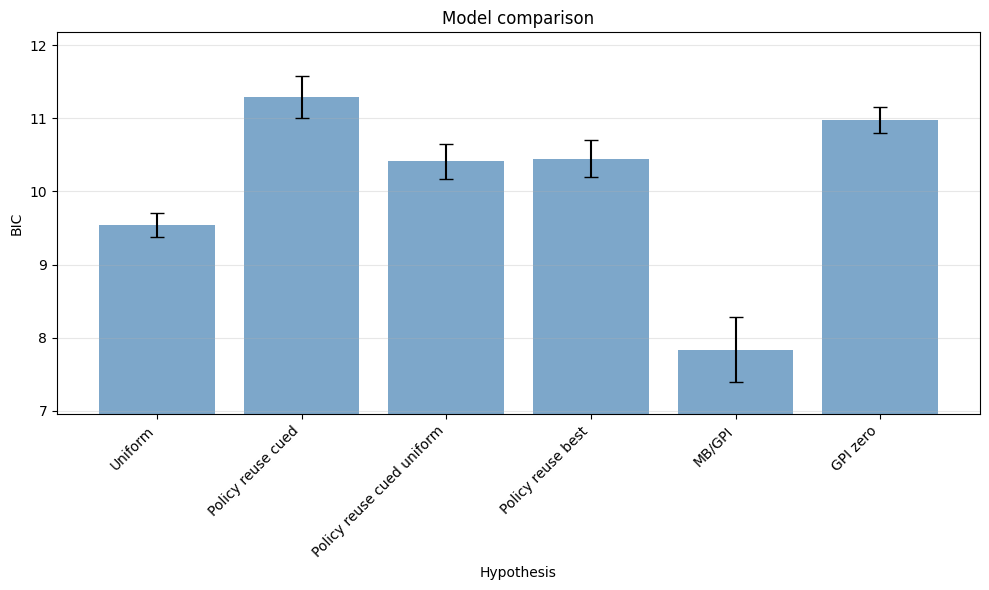

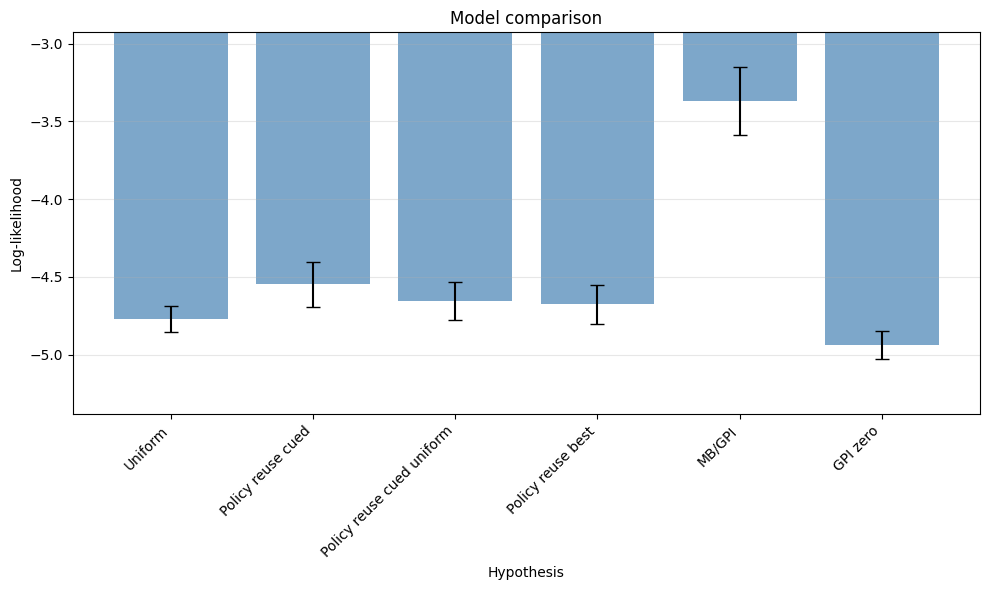

In [8]:
# Create bar plot of BICs with standard errors

# Calculate means and standard errors for BICs
def plot_model_comparison(data, metric_name, hypotheses):
    """Plot bar chart with error bars for model comparison metrics"""
    means = np.mean(data, axis=0)
    sems = np.std(data, axis=0) / np.sqrt(data.shape[0])
    
    # Get hypothesis names
    hypothesis_names = [H.name for H in hypotheses]
    
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(hypothesis_names)), means, yerr=sems, 
                   capsize=5, alpha=0.7, color='steelblue')
    
    # Customize the plot
    plt.xlabel('Hypothesis')
    plt.ylabel(metric_name)
    plt.title('Model comparison')
    plt.xticks(range(len(hypothesis_names)), hypothesis_names, rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.ylim(bottom=means.min() - 2*sems.max(), top=means.max() + 2*sems.max())
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    plt.savefig(f'results/{experiment_version}/model_comparison_{metric_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_model_comparison(bics, 'BIC', hypotheses)
plot_model_comparison(log_likelihoods, 'Log-likelihood', hypotheses)



In [9]:
# Group BMC

lmes = -0.5 * bics
bms = GroupBMC(lmes.transpose())
bms_result = bms.get_result()

print('BMS Protected Exceedance Probability:')
print('-' * 50)
for i, H in enumerate(hypotheses):
    prob = bms_result.protected_exceedance_probability[i]
    print(f'H{i}: {H.name:40s}: {prob:.2f}')
print('-' * 50)

BMS Protected Exceedance Probability:
--------------------------------------------------
H0: Uniform                                 : 0.00
H1: Policy reuse cued                       : 0.00
H2: Policy reuse cued uniform               : 0.00
H3: Policy reuse best                       : 0.00
H4: MB/GPI                                  : 1.00
H5: GPI zero                                : 0.00
--------------------------------------------------


In [10]:
# Group BMC with families

lmes = -0.5 * bics
if include_hybrids:
    partitions = [[1],[2,3,4],[5],[6],[7,8]]
else:
    partitions = [[1],[2,3,4],[5],[6]]
bms_fam = GroupBMC(lmes.transpose(), partitions=partitions)
bms_result_fam = bms_fam.get_result()

family_names = [
    'Uniform (H0)',
    'Policy reuse family (H1-H5)',
    'MB/GPI (H6)',
    'GPI zero (H7)',
]
if include_hybrids:
    family_names.append('GPI zero + Policy reuse (H8-H9)')

print('\nBMS Family Protected Exceedance Probability:')
print('-' * 50)
for i, family_name in enumerate(family_names):
    prob = bms_result_fam.protected_exceedance_probability[i]
    print(f'{family_name:40s}: {prob:.2f}')
print('-' * 50)


BMS Family Protected Exceedance Probability:
--------------------------------------------------
Uniform (H0)                            : 0.00
Policy reuse family (H1-H5)             : 0.00
MB/GPI (H6)                             : 1.00
GPI zero (H7)                           : 0.00
--------------------------------------------------
